多变量时间序列预测的工作原理与单变量时间序列预测类似。主要的区别是，你必须指定要预测的目标单变量的索引，例如，对于一个5个变量的时间序列，你可能想预测第3个变量的值（我们通过指示target_seq_index = 2来指定）

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from merlion.utils import TimeSeries
from merlion.models.forecast.arima import Arima, ArimaConfig
from merlion.models.forecast.smoother import MSES, MSESConfig
from merlion.models.forecast.vector_ar import VectorAR,VectorARConfig

from merlion.transform.base import Identity
from merlion.transform.resample import TemporalResample
from merlion.evaluate.forecast import ForecastMetric
from merlion.models.ensemble.combine import Mean, ModelSelector
from merlion.models.ensemble.forecast import ForecasterEnsemble, ForecasterEnsembleConfig
from merlion.models.factory import ModelFactory

import numpy as np
from sklearn.metrics import accuracy_score

plotly not installed, so plotly visualizations will not work.


In [60]:
# 参数
max_forecast_steps  = 100
order=(25, 0, 6)
target_seq_index = 0

In [40]:
def read_data(name):
    """
    读取数据
    """
    df = pd.read_csv(name)
    df['month'] = pd.to_datetime(df['month'])
    df = df.set_index('month')
    return df

In [41]:
def df_to_timeseries(df):
    """
    转换格式，划分数据集
    """
    time_series_train = TimeSeries.from_pd(df.iloc[:int(df.shape[0]*0.8),:])
    time_series_test = TimeSeries.from_pd(df.iloc[int(df.shape[0]*0.8):,:])
    return time_series_train,time_series_test

In [42]:
def get_target(test):
    """
    获取需要预测的目标变量真值
    """
    target_univariate = test.univariates[test.names[target_seq_index]]
    target = target_univariate[:max_forecast_steps].to_ts()
    return target

In [56]:
def build_model(order):
    """
    构造模型
    """
    config1 = ArimaConfig(max_forecast_steps=max_forecast_steps, target_seq_index=target_seq_index, order=order,
                          transform=Identity())
    model1 = Arima(config1)
    return model1

In [44]:
def assessment(forecast,df):
    pred = forecast.univariates['closeLogDiff']
    test_df = df.iloc[int(df.shape[0]*0.8):,:]
    test_df['forcast'] = pred
    test_df = test_df[['closeLogDiff','forcast']]
    test_df['true_tend']=np.where(test_df.closeLogDiff >= 0, 1, 0)
    test_df['pred_tend']=np.where(test_df.forcast >= 0, 1, 0)
#     accuracy = accuracy_score(test_df['true_tend'],test_df['pred_tend'])
#     print(f'相同趋势准确率{accuracy:.4f}')
    a = len(test_df[test_df['closeLogDiff']>0][test_df['forcast']>0])
    b = len(test_df[test_df['closeLogDiff']<0][test_df['forcast']<0])
    accuracy = (a+b)/len(test_df)
    print(f'相同趋势准确率{accuracy:.4f}')
    return test_df,accuracy

In [30]:
train6.to_pd()['closeLogDiff']

2001-01-01   -0.085514
2001-02-01   -0.020605
2001-03-01    0.004219
2001-04-01    0.014296
2001-05-01    0.015411
                ...   
2016-11-01    0.024800
2016-12-01    0.064264
2017-01-01    0.081417
2017-02-01    0.104942
2017-03-01    0.107965
Freq: MS, Name: closeLogDiff, Length: 195, dtype: float64

<ipython-input-54-9c5935b82697>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  pacf.show()
<ipython-input-54-9c5935b82697>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acf.show()


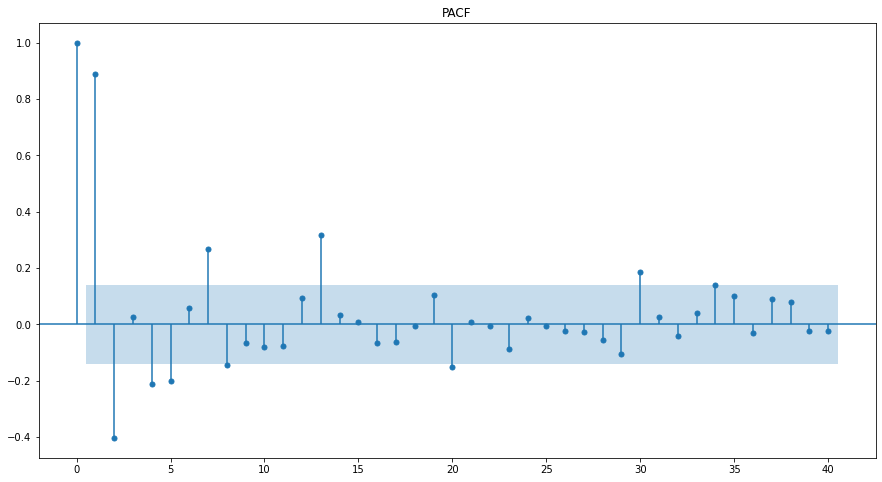

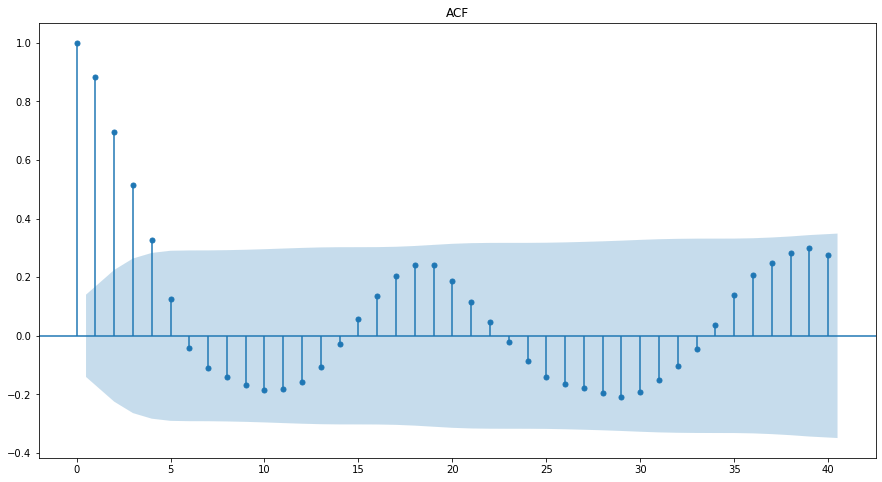

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams['figure.figsize'] = [15, 8]

pacf = plot_pacf(train6.to_pd()['closeLogDiff'], lags=40)
plt.title('PACF')
pacf.show()

acf = plot_acf(train6.to_pd()['closeLogDiff'], lags=40)
plt.title('ACF')
acf.show()

Training Arima...
Arima
RMSE:  0.0343
sMAPE: 120.4217



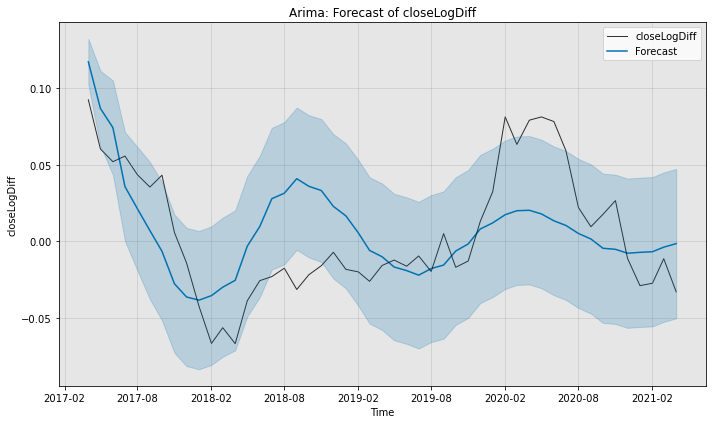

相同趋势准确率0.7143


<ipython-input-44-1428e82f15e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['forcast'] = pred
<ipython-input-44-1428e82f15e8>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = len(test_df[test_df['closeLogDiff']>0][test_df['forcast']>0])
<ipython-input-44-1428e82f15e8>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = len(test_df[test_df['closeLogDiff']<0][test_df['forcast']<0])


In [63]:
if __name__=='__main__':
    df6 = read_data('Predict_Data_6.csv')
    train6,test6 = df_to_timeseries(df6)
    target6 = get_target(test6)
    model1 = build_model(order)

    # 训练模型
    for model in [model1]:
        print(f"Training {type(model).__name__}...")
        train_pred6, train_stderr6 = model.train(train6)
        
    # 进行预测
    for model in [model1]:
        forecast6, stderr6 = model.forecast(target6.time_stamps)
        rmse = ForecastMetric.RMSE.value(ground_truth=target6, predict=forecast6)
        smape = ForecastMetric.sMAPE.value(ground_truth=target6, predict=forecast6)
        print(f"{type(model).__name__}")
        print(f"RMSE:  {rmse:.4f}")
        print(f"sMAPE: {smape:.4f}")
        print()
        
        # 可视化
        fig6, ax6 = model.plot_forecast(time_series=test6, plot_forecast_uncertainty=True)
        plt.show()
        fig6.savefig('C:/Users/TANGLINGHUI331/Desktop/Arima预测_6')
    
    result_data,accuracy = assessment(forecast6,df6)

Training Arima...
Arima
RMSE:  0.0136
sMAPE: 155.5079



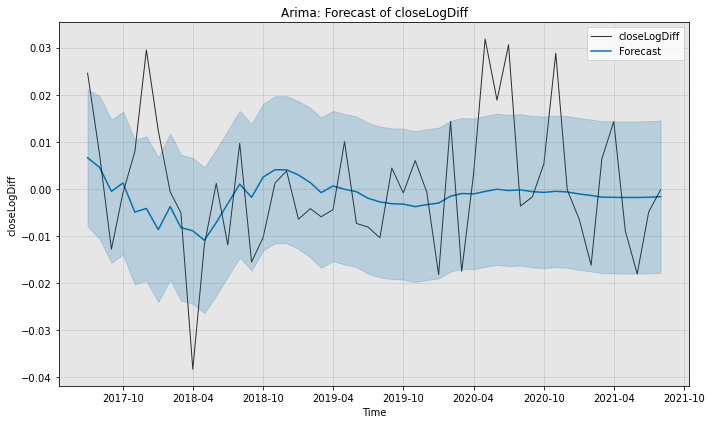

相同趋势准确率0.5800


<ipython-input-147-1428e82f15e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['forcast'] = pred
<ipython-input-147-1428e82f15e8>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = len(test_df[test_df['closeLogDiff']>0][test_df['forcast']>0])
<ipython-input-147-1428e82f15e8>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = len(test_df[test_df['closeLogDiff']<0][test_df['forcast']<0])


In [170]:
if __name__=='__main__':
    df1 = read_data('Predict_Data_1.csv')
    train1,test1 = df_to_timeseries(df1)
    target1 = get_target(test1)
    model1 = build_model(order=(20,1,6))

    # 训练模型
    for model in [model1]:
        print(f"Training {type(model).__name__}...")
        train_pred1, train_stderr1 = model.train(train1)
        
    # 进行预测
    for model in [model1]:
        forecast1, stderr1 = model.forecast(target1.time_stamps)
        rmse = ForecastMetric.RMSE.value(ground_truth=target1, predict=forecast1)
        smape = ForecastMetric.sMAPE.value(ground_truth=target1, predict=forecast1)
        print(f"{type(model).__name__}")
        print(f"RMSE:  {rmse:.4f}")
        print(f"sMAPE: {smape:.4f}")
        print()
        
        # 可视化
        fig1, ax1 = model.plot_forecast(time_series=test1, plot_forecast_uncertainty=True)
        plt.show()

 #       fig1.savefig('C:/Users/TANGLINGHUI331/Desktop/Arima预测_1')
    
    result_data1,accuracy1 = assessment(forecast1,df1)

Training Arima...
Arima
RMSE:  0.0208
sMAPE: 143.6658



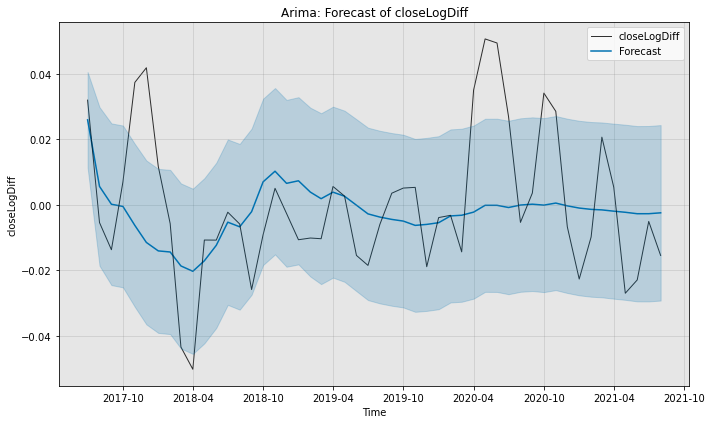

相同趋势准确率0.5800


<ipython-input-147-1428e82f15e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['forcast'] = pred
<ipython-input-147-1428e82f15e8>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = len(test_df[test_df['closeLogDiff']>0][test_df['forcast']>0])
<ipython-input-147-1428e82f15e8>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = len(test_df[test_df['closeLogDiff']<0][test_df['forcast']<0])


In [174]:
if __name__=='__main__':
    df2 = read_data('Predict_Data_2.csv')
    train2,test2 = df_to_timeseries(df2)
    target2 = get_target(test2)
    model2 = build_model(order=(20,1,6))

    # 训练模型
    for model in [model2]:
        print(f"Training {type(model).__name__}...")
        train_pred2, train_stderr2 = model.train(train2)
        
    # 进行预测
    for model in [model2]:
        forecast2, stderr2 = model.forecast(target2.time_stamps)
        rmse = ForecastMetric.RMSE.value(ground_truth=target2, predict=forecast2)
        smape = ForecastMetric.sMAPE.value(ground_truth=target2, predict=forecast2)
        print(f"{type(model).__name__}")
        print(f"RMSE:  {rmse:.4f}")
        print(f"sMAPE: {smape:.4f}")
        print()
        
        # 可视化
        fig2, ax2 = model.plot_forecast(time_series=test2, plot_forecast_uncertainty=True)
        plt.show()

#        fig2.savefig('C:/Users/TANGLINGHUI331/Desktop/Arima预测_2')
    
    result_data2,accuracy2 = assessment(forecast2,df2)

Training Arima...
Arima
RMSE:  0.0276
sMAPE: 141.1564



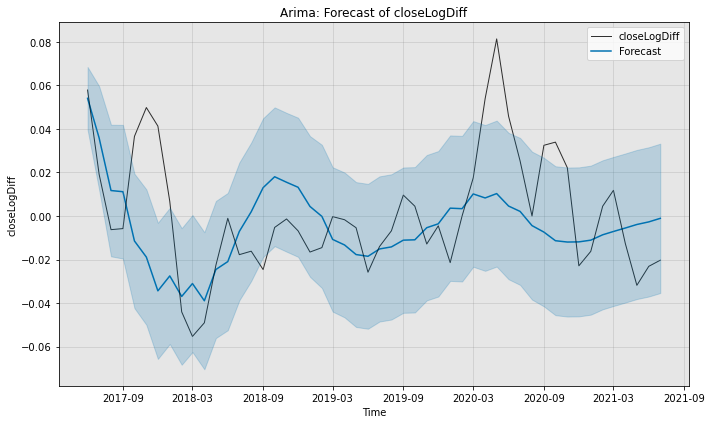

相同趋势准确率0.6000


<ipython-input-147-1428e82f15e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['forcast'] = pred
<ipython-input-147-1428e82f15e8>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = len(test_df[test_df['closeLogDiff']>0][test_df['forcast']>0])
<ipython-input-147-1428e82f15e8>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = len(test_df[test_df['closeLogDiff']<0][test_df['forcast']<0])


In [180]:
if __name__=='__main__':
    df3 = read_data('Predict_Data_3.csv')
    train3,test3 = df_to_timeseries(df3)
    target3 = get_target(test3)
    model3 = build_model(order=(26,1,6))

    # 训练模型
    for model in [model3]:
        print(f"Training {type(model).__name__}...")
        train_pred3, train_stderr3 = model.train(train3)
        
    # 进行预测
    for model in [model3]:
        forecast3, stderr3 = model.forecast(target3.time_stamps)
        rmse = ForecastMetric.RMSE.value(ground_truth=target3, predict=forecast3)
        smape = ForecastMetric.sMAPE.value(ground_truth=target3, predict=forecast3)
        print(f"{type(model).__name__}")
        print(f"RMSE:  {rmse:.4f}")
        print(f"sMAPE: {smape:.4f}")
        print()
        
        # 可视化
        fig3, ax3 = model.plot_forecast(time_series=test3, plot_forecast_uncertainty=True)
        plt.show()

        fig3.savefig('C:/Users/TANGLINGHUI331/Desktop/Arima预测_3')
    
    result_data3,accuracy3 = assessment(forecast3,df3)

In [142]:
from merlion.models.factory import ModelFactory
kwargs = dict(target_seq_index=target_seq_index, max_forecast_steps=max_forecast_steps)
model1 = ModelFactory.create("LGBMForecaster", target_seq_index=target_seq_index, max_forecast_steps=max_forecast_steps,prediction_stride=1,maxlags=35,n_estimators=100,max_depth=7,sampling_mode="normal",learning_rate=0.1)

In [152]:
train_pred1, train_stderr1 = model1.train(train6)

LGBMForecaster
RMSE:  0.0703
sMAPE: 114.6757



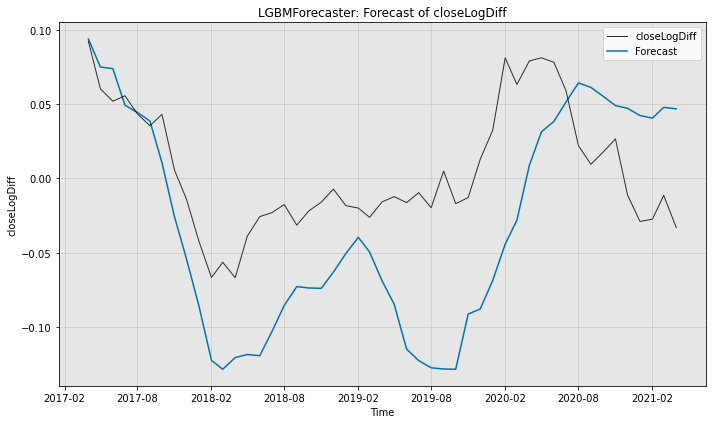

相同趋势准确率0.7755


<ipython-input-44-1428e82f15e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['forcast'] = pred
<ipython-input-44-1428e82f15e8>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = len(test_df[test_df['closeLogDiff']>0][test_df['forcast']>0])
<ipython-input-44-1428e82f15e8>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = len(test_df[test_df['closeLogDiff']<0][test_df['forcast']<0])


In [153]:
target1 = get_target(test6)
forecast1, stderr1 = model1.forecast(target1.time_stamps)
rmse = ForecastMetric.RMSE.value(ground_truth=target1, predict=forecast1)
smape = ForecastMetric.sMAPE.value(ground_truth=target1, predict=forecast1)
print(f"{type(model1).__name__}")
print(f"RMSE:  {rmse:.4f}")
print(f"sMAPE: {smape:.4f}")
print()

# 可视化
fig2, ax2 = model1.plot_forecast(time_series=test6,time_series_prev=train6)
plt.show()

#        fig2.savefig('C:/Users/TANGLINGHUI331/Desktop/Arima预测_2')

result_data2,accuracy2 = assessment(forecast1,df6)

In [ ]:
config1 = ArimaConfig(max_forecast_steps=max_forecast_steps, target_seq_index=target_seq_index, order=order,
                      transform=Identity())
model1 = Arima(config1)

In [156]:
from merlion.models.forecast.boostingtrees import LGBMForecasterConfig,LGBMForecaster,BoostingTreeForecasterConfig,BoostingTreeForecaster,

In [ ]:
# 参数
target_seq_index = 0
max_forecast_steps  = 100
prediction_stride=1
maxlag = 35
n_estimators=100
max_depth=7
learning_rate=0.1

In [ ]:
kwargs = dict(target_seq_index=target_seq_index, max_forecast_steps=max_forecast_steps)
model1 = ModelFactory.create()